# Performance

This notebook reproduces the charts on performance of the datalab, assesing different types of data access from different locations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
hub = pd.read_csv("lustre-load2.csv")
ifca = pd.read_csv("hub-load2.csv")

hub["location"] = "Lustre"
ifca["location"] = "Hub"

In [3]:
hub["bytes_recv"] = hub["bytes_recv"] / 2**20
ifca["bytes_recv"] = ifca["bytes_sent"] / 2**20

ifca["throughput"] = ifca["bytes_recv"] / ifca["time"]
hub["throughput"] = hub["bytes_recv"] / hub["time"]
hub.loc[hub["name"]=="local","throughput"] = (38 * 2**10) / hub[hub["name"]=="local"]["time"]
ifca.loc[ifca["name"]=="local","throughput"] = (38 * 2**10) / ifca[ifca["name"]=="local"]["time"]

hub.loc[hub["name"]=="local", "name"] = "netCDF\n(~38 GiB)"
hub.loc[hub["name"]=="opendap-hub-compressed", "name"] = "OPeNDAP\n(deflate=True, ~48 GiB)"
hub.loc[hub["name"]=="opendap-hub-uncompressed", "name"] = "OPeNDAP\n(deflate=False, ~87 GiB)"

ifca.loc[ifca["name"]=="local", "name"] = "netCDF\n(~38 GiB)"
ifca.loc[ifca["name"]=="opendap-hub-compressed", "name"] = "OPeNDAP\n(deflate=True, ~48 GiB)"
ifca.loc[ifca["name"]=="opendap-hub-uncompressed", "name"] = "OPeNDAP\n(deflate=False, ~87 GiB)"

In [4]:
hub_mean = hub[["name", "workers", "location", "time", "bytes_recv", "throughput"]].groupby(["location", "name", "workers"]).agg(["mean", "std", "max", "min"])
ifca_mean = ifca[["name", "workers", "location", "time", "bytes_recv", "throughput"]].groupby(["location", "name", "workers"]).agg(["mean", "std", "max", "min"])

In [5]:
hub_mean

time             \
                                                           mean        std   
location name                              workers                           
Lustre   OPeNDAP\n(deflate=False, ~87 GiB) 1        5737.615137        NaN   
                                           2        3137.267253   6.332751   
                                           4        1984.935914  16.782157   
                                           8        1385.791224  19.473409   
         OPeNDAP\n(deflate=True, ~48 GiB)  1        6165.105022   7.358635   
                                           2        3362.784462  37.204752   
                                           4        1980.287331  15.089154   
                                           8        1248.375824  13.827741   

                                                                              \
                                                            max          min   
location name                              workers                             
Lustre   OPeNDAP\n(deflate=False, ~87 GiB) 1        5737.615137  5737.615137   
                                           2        3144.547559  3133.034146   
                                           4        2004.291705  1974.448204   
                                           8        1407.637527  1370.256356   
         OPeNDAP\n(deflate=True, ~48 GiB)  1        6170.308363  6159.901681   
                                           2        3389.092195  3336.476730   
                                           4        1990.956974  1969.617687   
                                           8        1258.153513  1238.598134   

                                                       bytes_recv  \
                                                             mean   
location name                              workers                  
Lustre   OPeNDAP\n(deflate=False, ~87 GiB) 1        144456.089571   
                                           2        121768.949259   
                                           4        110308.744814   
                                           8        106550.908547   
         OPeNDAP\n(deflate=True, ~48 GiB)  1         54127.067606   
                                           2         56487.990737   
                                           4         51938.917492   
                                           8         51832.648480   

                                                                 \
                                                            std   
location name                              workers                
Lustre   OPeNDAP\n(deflate=False, ~87 GiB) 1                NaN   
                                           2         441.374528   
                                           4        1233.001109   
                                           8         717.589379   
         OPeNDAP\n(deflate=True, ~48 GiB)  1        3244.688005   
                                           2          94.161017   
                                           4         150.176572   
                                           8           0.373828   

                                                                   \
                                                              max   
location name                              workers                  
Lustre   OPeNDAP\n(deflate=False, ~87 GiB) 1        144456.089571   
                                           2        122266.233491   
                                           4        111341.058103   
                                           8        107379.448511   
         OPeNDAP\n(deflate=True, ~48 GiB)  1         56421.408498   
                                           2         56554.572631   
                                           4         52045.108365   
                                           8         51832.912817   

                                                             

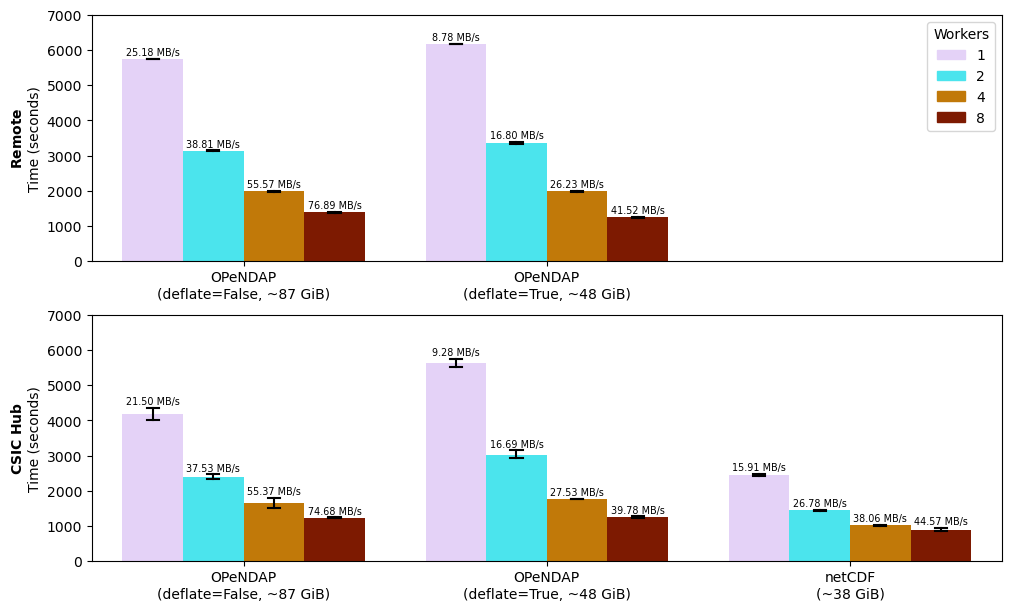

In [6]:
fig, axes = plt.subplots(2, 1, layout='constrained', figsize=(10, 6), sharey=False)

workers = [1, 2, 4, 8]
workers_colors = ["#E4D2F7", "#4BE4ED", "#C17909", "#7D1A01"]
workers_color_dict = dict(zip(workers, workers_colors))

time_means = hub_mean[("time", "mean")].values
time_workers = hub_mean[("time", "mean")].index.get_level_values("workers")

bar_width = 0.1

axes[0].bar(
    [0,1,2,3] + [5,6,7,8], # + [10,11,12,13],
    time_means,
    color = time_workers.map(workers_color_dict).values,
    width=1)

axes[0].set_xticks(
    [1.5,6.5], [b for a,b,_ in hub_mean.index[::4].values])
#axes[0].set_ylabel("Remote\nTime (seconds)")
axes[0].set_ylabel("$\mathbf{Remote}$\nTime (seconds)")

for i,row in enumerate([0,1,2,3,5,6,7,8]):
    axes[0].plot([row,row], [hub_mean[("time", "min")].iloc[i], hub_mean[("time", "max")].iloc[i]], c="black")
    axes[0].text(row, hub_mean[("time", "max")].iloc[i] + 100,
                 f"{hub_mean[('throughput', 'mean')].iloc[i]:.2f} MB/s",
                 ha="center", size="x-small")

    # Add horizontal bars at the top and bottom
    axes[0].plot([row - bar_width, row + bar_width], 
                 [hub_mean[("time", "min")].iloc[i], hub_mean[("time", "min")].iloc[i]], 
                 c="black")  # Bottom bar
    axes[0].plot([row - bar_width, row + bar_width], 
                 [hub_mean[("time", "max")].iloc[i], hub_mean[("time", "max")].iloc[i]], 
                 c="black")  # Top bar

time_means = ifca_mean[("time", "mean")].values
time_workers = ifca_mean[("time", "mean")].index.get_level_values("workers")

axes[1].bar(
    [0,1,2,3] + [5,6,7,8] + [10,11,12,13],
    time_means,
    color = time_workers.map(workers_color_dict).values,
    width=1)

axes[1].set_xticks(
    [1.5,6.5,11.5], [b for a,b,_ in ifca_mean.index[::4].values])
#axes[1].set_ylabel("CSIC Hub\nTime (seconds)")
axes[1].set_ylabel("$\mathbf{CSIC\ Hub}$\nTime (seconds)")

for i,row in enumerate([0,1,2,3,5,6,7,8,10,11,12,13]):
    axes[1].plot([row,row], [ifca_mean[("time", "min")].iloc[i], ifca_mean[("time", "max")].iloc[i]], c="black")
    #if i < 8:
    axes[1].text(row, ifca_mean[("time", "max")].iloc[i] + 100,
                 f"{ifca_mean[('throughput', 'mean')].iloc[i]:.2f} MB/s",
                 ha="center", size="x-small")

    # Add horizontal bars at the top and bottom
    axes[1].plot([row - bar_width, row + bar_width], 
                 [ifca_mean[("time", "min")].iloc[i], ifca_mean[("time", "min")].iloc[i]], 
                 c="black")  # Bottom bar
    axes[1].plot([row - bar_width, row + bar_width], 
                 [ifca_mean[("time", "max")].iloc[i], ifca_mean[("time", "max")].iloc[i]], 
                 c="black")  # Top bar

axes[0].legend(handles=[plt.Rectangle((0,0),1,1, color=workers_color_dict[label]) for label in workers], labels=workers, title="Workers")
axes[0].set_xlim(-1, 14)
axes[1].set_xlim(-1, 14)
axes[0].set_ylim(0, 7000)
axes[1].set_ylim(0, 7000)

# l1 = axes[0].axhline(y=1000, color='grey', linestyle='-', linewidth=.5, zorder=0)
# l2 = axes[1].axhline(y=1000, color='grey', linestyle='-', linewidth=.5, zorder=0)
# l1.set_dashes([10, 25])  # [dash_length, space_length]
# l2.set_dashes([10, 25])

plt.savefig("performance.png", dpi=600)